# Pre-processing of DWI data


Before we can apply any model fitting to our data, we first need to apply a number of pre-processing steps to improve data quality and mitigation of artefacts. First we must load the AP and PA data, using the tools covered in Tutorial 1.  

In [31]:
#load general modules
import os
import numpy as np

#load dipy modules
import dipy
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs


#load modules for visualizations
import matplotlib.pyplot as plt

#define the paths to the data
scripts_dir = os.getcwd()
bids_dir = f"{scripts_dir[0:61]}/data/bids"
out_dir = f"{scripts_dir[0:61]}/data/derivatives"

#subject code to be used in this example
sub='01'

#define path to dwi data
dwi_path = f"{bids_dir}/sub-{sub}/dwi"

#find the relevant files and save file names into specific variables

for item in os.listdir(dwi_path):
    if item.endswith('AP_dwi.nii'):
        dwi_ap_file = item
    if item.endswith('AP_dwi.bvec'):
        dwi_ap_bvec = item
    if item.endswith('AP_dwi.bval'):
        dwi_ap_bval = item
    if item.endswith('PA_dwi.nii'):
        dwi_pa_file = item


#load the dwi raw data for phase encoding direction AP
dwi_ap_data, dwi_ap_affine = load_nifti(f"{dwi_path}/{dwi_ap_file}")

#load bvals and bevecs for phase encoding direction AP
bvals, bvecs = read_bvals_bvecs(f"{dwi_path}/{dwi_ap_bval}", f"{dwi_path}/{dwi_ap_bvec}")

#load the dwi raw data for phase encoding direction PA
dwi_pa_data, dwi_pa_affine = load_nifti(f"{dwi_path}/{dwi_pa_file}")

#check if a folder already exists for the output data for this subject, create it if not
preproc_path = f"{out_dir}/preprocessing/sub-{sub}"

if not os.path.exists(preproc_path):
    os.makedirs(preproc_path)

## Denoising (optional)

The first (optional) pre-processing step for diffusion MRI data is denoising. Interpolation or smoothing in other processing steps, such as motion and distortion correction, may alter the noise characteristics and thus violate the assumptions upon which the denoising algorithm is based. Therefore image denoising must be performed as the first step of the image-processing pipeline. Here we will use the Marcenko-Pastur PCA algorithm for denoising. 

Internally, the mppca algorithm denoises the diffusion-weighted data using a 3D sliding window which is defined by the variable patch_radius. In total, this window should comprise a larger number of voxels than the number of diffusion-weighted volumes. Since our data has a total of 102 volumes, the patch_radius is set to 2 which corresponds to a 5x5x5 sliding window comprising a total of 125 voxels.

This can take a long time depending on the size of your dataset. 

In [3]:
from time import time

# load main pca function using Marcenko-Pastur distribution
from dipy.denoise.localpca import mppca

#select the middle slice 
mid_slice = dwi_ap_data.shape[2] // 2

#check whether this step has been previously run
den_file_path = f"{out_dir}/preprocessing/sub-{sub}/denoised_ap_mppca.nii.gz"

#if denoising has not been run, run the denoising step
if not os.path.exists(den_file_path):

    # denoise the dwi data using local MP-PCA
    t = time()

    #denoise the full dataset - takes 5-6 minutes to run
    denoised_ap = mppca(dwi_ap_data, patch_radius=2)

    print("Time taken for local MP-PCA ", -t + time())


To assess the performance of the denoising algorithm, we can now plot the orginal data, denoised data and the residuals. We always recommend eyeballing the residuals, i.e. original - denoised, as part of the quality control. The lack of anatomy in the residual maps is a marker of accuracy and signal-preservation during denoising. 

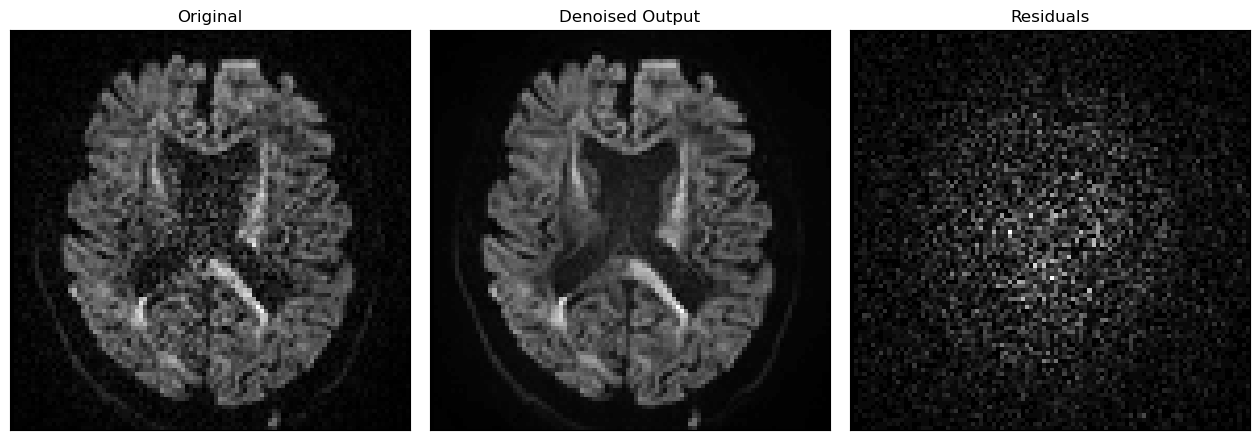

In [8]:
#if the denoising had been run previous, load the denoised data
den_file_path = f"{out_dir}/preprocessing/sub-{sub}/denoised_ap_mppca.nii.gz"

if 'denoised_ap' not in locals():
    denoised_ap, _ = load_nifti(den_file_path)

#select the middle slice 
mid_slice_den = denoised_ap.shape[2] // 2

#select a volume for the highes b-value, where denoising is most important
bval_id = np.where(bvals == max(bvals))[0][0]

orig = dwi_ap_data[:, :, mid_slice, bval_id]
den = denoised_ap[:, :, mid_slice_den, bval_id]
rms_diff = np.sqrt((orig - den) ** 2)

fig1, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(orig.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[0].set_title('Original')
ax.flat[1].imshow(den.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[1].set_title('Denoised Output')
ax.flat[2].imshow(rms_diff.T, cmap='gray', interpolation='none',
                  origin='lower')
ax.flat[2].set_title('Residuals')

fig1.savefig(f"{out_dir}/preprocessing/sub-{sub}/denoised_mppca.png")

Finally, we can save the denoised data:

In [5]:
#check whether the denoised file exists
den_file_path = f"{out_dir}/preprocessing/sub-{sub}/denoised_ap_mppca.nii.gz"

#if the file doesn't exist, save the denoised data
if not os.path.exists(den_file_path):
    save_nifti(den_file_path, denoised_ap, dwi_ap_affine)


## Removal of Gibbs artefacts (optional)

Gibbs artefacts can be seen as intensity oscillations near the edges of different tissue types. These are a consequence of how we collect and reconstruct MRI data: MRI images are reconstructed from the Fourier coefficients of the k-space data collected during MRI acquisition; in theory, the Frourier series has infinite terms, but in practice we can only have a finite number of coefficients, and it is this series truncation which can lead to artefacts. Gibbs artefacts can affect all MRI modalities, but they can be particularly problematic for diffusion MRI data, as these are usually acquired with a small field of view. 

Gibbs correction should run on data directly after it has been reconstructed by the scanner, before any interpolation of any kind has taken place. You should not run this command after any form of motion correction for example. However, if you intend on denoising your data, you should do so before Gibbs removal so to not alter the noise structure, which would impact the performance of the denoising algorithm.

The algorithm implemented in dipy is based on the sub-voxel Gibbs suppression procedure described by Kellner and colleagues in their 2016 paper (REF). 


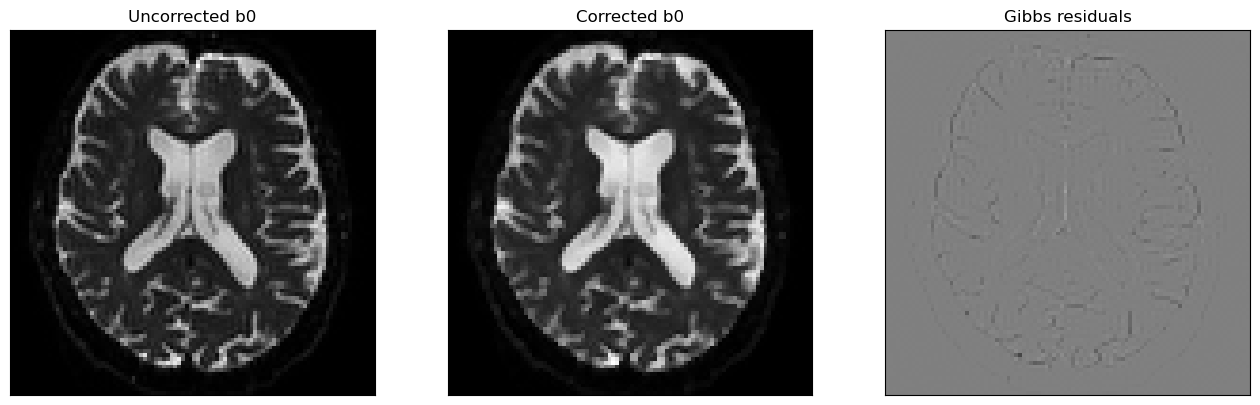

In [7]:
from dipy.denoise.gibbs import gibbs_removal

#check whether the Gibbs corrected file exists and if it doesn't, run the Gibbs correction
gibbs_file_path = f"{out_dir}/preprocessing/sub-{sub}/nogibbs_ap_mppca.nii.gz"

if not os.path.exists(gibbs_file_path):

    #load the whole brain denoised data from previously saved file
    den_file_path = f"{out_dir}/preprocessing/sub-{sub}/denoised_ap_mppca.nii.gz"
    denoised_ap, den_ap_affine = load_nifti(den_file_path)

    #apply the Gibbs removal algorithm to the data   
    nogibbs_ap = gibbs_removal(denoised_ap, slice_axis=2, num_processes=-1)

    #save the Gibbs corrected data
    save_nifti(f"{out_dir}/preprocessing/sub-{sub}/nogibbs_ap_mppca.nii.gz", nogibbs_ap, dwi_ap_affine)

else:
    nogibbs_ap, _ = load_nifti(gibbs_file_path)

#visualise the impact of Gibbs correction on the b0 image
fig2, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(denoised_ap[:, :, mid_slice, 0].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('Uncorrected b0')
ax.flat[1].imshow(nogibbs_ap[:, :, mid_slice, 0].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('Corrected b0')
ax.flat[2].imshow(nogibbs_ap[:, :, mid_slice, 0].T - denoised_ap[:, :,mid_slice, 0].T, cmap='gray', interpolation='none', origin='lower', vmin=-1000, vmax=1000)
ax.flat[2].set_title('Gibbs residuals')

plt.show()
#fig2.savefig('Gibbs_suppression_b0.png')

## EPI distortion correction

In Tutorial 1 we saw that EPI images are affected by distortions which are caused by differences in the magnetic susceptibilities of the areas being imaged. The 'state-of-the-art' method to correct for these distortions is a tool called TOPUP, which is part of the FSL software (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki). We will be calling this tool from our python script using the python subprocess module. Please note that it is a prerequisite that FSL is installed on your system and its binaries are included in your system's path. 


### TOPUP - Correcting for Susceptibility-induced Distortions 

FSL topup wiki: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup 

A minimum requirement for using topup for correcting distortions is that two spin-echo (SE) EPI images with different PE-directions have been acquired. The best is to acquire them with opposing PE-directions (i.e. A→P AND P→A or L→R AND R→L). An SE-EPI image is the same as a b=0 image acquired as a part of a diffusion protocol. Just as for fieldmaps, this pair must be acquired at the same occasion as the full diffusion protocol and the subject must not leave the scanner in between and no re-shimming can be done.

From the denoised and GIbbs corrected files, choose a volume without diffusion weighting (e.g. the first volume). You can extract this as a standalone 3D image and call the extracted files nodif_AP/PA.

Text(0.5, 1.0, 'b0 image PA direction')

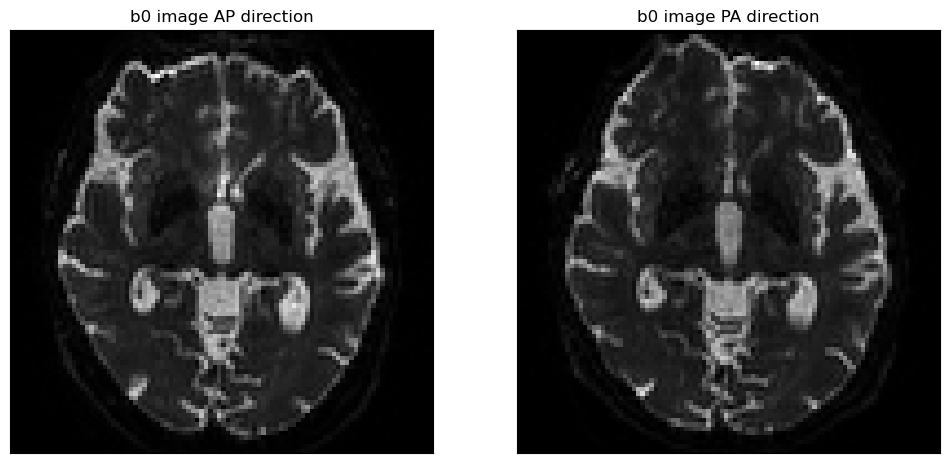

In [11]:
#load the original dwi data ap and pa

#phase encoding direction AP
dwi_ap_data, dwi_ap_affine = load_nifti(f"{dwi_path}/{dwi_ap_file}")

#phase encoding direction PA
dwi_pa_data, dwi_pa_affine = load_nifti(f"{dwi_path}/{dwi_pa_file}")

#extract the b0 images (first imaging volume) for both phase encoding directions
nodif_ap = dwi_ap_data[:,:,:,0]
nodif_pa = dwi_pa_data[:,:,:]

#plot the slice 25 for each PE direction
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(nodif_ap[:, :, 25].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('b0 image AP direction')
ax.flat[1].imshow(nodif_pa[:, :, 25].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('b0 image PA direction')


You can see that regions that are squashed in the AP data appear elongated in the PA data and vice versa. Unsurprisingly the areas that were very obviously distorted when viewed in the nodif_ap image change a lot when you comapare them to the nodif_pa image. We will correct these distortions by combining the two b=0 images using the TOPUP tool. The next step is to merge the nodiff_ap and nodiff_pa files along the 4th 'timeseries' axis. Call the merged image ap_pa_b0. 

In [12]:
#concatenate the data along the 4th dimension
ap_pa_b0 = np.stack((nodif_ap, nodif_pa), axis=-1)

#save the concatenated data
save_nifti(f"{out_dir}/preprocessing/sub-{sub}/ap_pa_b0.nii.gz", ap_pa_b0, dwi_ap_affine)

Then create a text file that contains the information with the PE direction, the sign of the AP and PA volumes and some timing information obtained by the acquisition. This is a text-file called acqparams.txt that contains the lines:

0 -1 0 0.0266003<br>
0  1 0 0.0266003

The first three elements of each line comprise a vector that specifies the direction of the phase encoding. The non-zero number in the second column means that is along the y-direction. A -1 means that k-space was traversed Anterior→Posterior and a 1 that it was traversed Posterior→Anterior. The final column specifies the "total readout time", which is the time (in seconds) between the collection of the centre of the first echo and the centre of the last echo. In the FAQ section of the online help for topup there are instructions for how to find this information for Siemens scanners (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/topup/Faq). The file should contain as many entries as there are volumes in the image file that is passed to topup.

In [15]:
#check whether the acqparams.txt file exists and create it if it doesn't
acq_file_path = f"{out_dir}/preprocessing/sub-{sub}/acqparams.txt"

if not os.path.exists(acq_file_path):

    #create the acqparams.txt file

    lines = [
        "0 -1 0 0.0266003\n",
        "0  1 0 0.0266003\n"
    ]

    # Open the file in write mode and write the lines
    with open(acq_file_path, 'w') as file:
        file.writelines(lines)

We are now ready to run topup which we will do using the python subprocess module:

In [17]:
import subprocess

#check whether the topup output file existes, and if not run topup
topup_file_path = f"{out_dir}/preprocessing/sub-{sub}/topup_ap_pa_b0_corrected.nii.gz"

if not os.path.exists(topup_file_path):

    # Define the command to load the FSL module and then execute topup
    def run_topup(config_file, input_file, output_base, acq_params_file):

        #command = f"module load fsl; topup --config={config_file} --datain={acq_params_file} --imain={input_file} --out={output_base} --iout={output_base}_corrected --fout={output_base}_field --logout={output_base}_log.txt"

        command = (
            f'module load fsl/6.0.5; '
            f'topup --config={config_file} '
            f'--datain={acq_params_file} '
            f'--imain={input_file} '
            f'--out={output_base} '
            f'--iout={output_base}_corrected '
            f'--fout={output_base}_field '
            f'--logout={output_base}_log.txt'
        )

        # Execute the command
        try:
            result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print("TOPUP completed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"An error occurred: {e}")
            print("Output:\n", e.stdout)
            print("Errors:\n", e.stderr)


    # Define paths to the relevant files
    config_file = 'b02b0.cnf'
    input_file_topup = f"{out_dir}/preprocessing/sub-{sub}/ap_pa_b0.nii.gz"
    output_base_topup = f"{out_dir}/preprocessing/sub-{sub}/topup_ap_pa_b0"
    acq_params_file = f"{out_dir}/preprocessing/sub-{sub}/acqparams.txt"


    # Run TOPUP
    run_topup(config_file, input_file_topup, output_base_topup, acq_params_file)

This command may take a long time to run, depending on the size of the dataset. 

There are four result files. topup_ap_pa_b0_fieldcoef.nii.gz contains information about the off-resonance field and topup_ap_pa_b0_movpar.txt specifies any movement between nodif_ap and nodif_pa. To visualise the results, we can use FSL's viewer FSLeyes.

Open FSLeyes and load topup_AP_PA_b0_fieldcoef.nii.gz. It looks like a low resolution fieldmap, and it contains the spline coefficients for the field that TOPUP has estimated. Close FSLeyes and re-open it, but this time take a look at the actual field (topup_AP_PA_b0_fout). Moreover, to check that TOPUP has done its job properly, load topup_AP_PA_b0_iout and compare its two volumes to those we provided as input (AP_PA_b0.nii.gz).

For a quick inspection of the corrected b0 volumes, you can run the code below. You can see that the sharp distortions in frontal regions are no longer present.

Text(0.5, 1.0, 'Corrected b0 image PA direction')

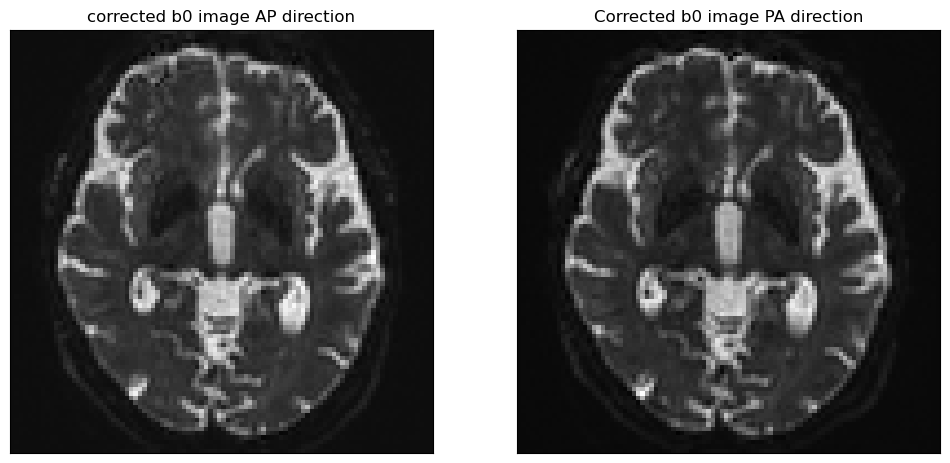

In [18]:
#load topup corrected data
topup_data, topup_affine = load_nifti(f"{out_dir}/preprocessing/sub-{sub}/topup_ap_pa_b0_corrected.nii.gz")

#plot the slice 25 for each PE direction
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(topup_data[:, :, 25, 0].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('corrected b0 image AP direction')
ax.flat[1].imshow(topup_data[:, :, 25, 1].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('Corrected b0 image PA direction')


## EDDY - Correcting for Eddy Currents

Again, the state-of-the-art tool for this step is part of the FSL software. EDDY performs eddy current and head movement correction simultaneously, and it also takes into account the output from TOPUP.

FSL wiki: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddy 

The first step is to generate a brain mask using the TOPUP corrected b0 images, starting by computing the average image of the corrected b0 volumes and naming the output file hifi_nodif. 


In [19]:
#average the two corrected b0 images
hifi_nodif = np.mean(topup_data, axis=3)

#save the average b0 image
save_nifti(f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif.nii.gz", hifi_nodif, topup_affine)



Next, we create a binary brain mask using the averaged b0 and name the output file hifi_nodif_brain. 

Text(0.5, 1.0, 'Binary brain mask')

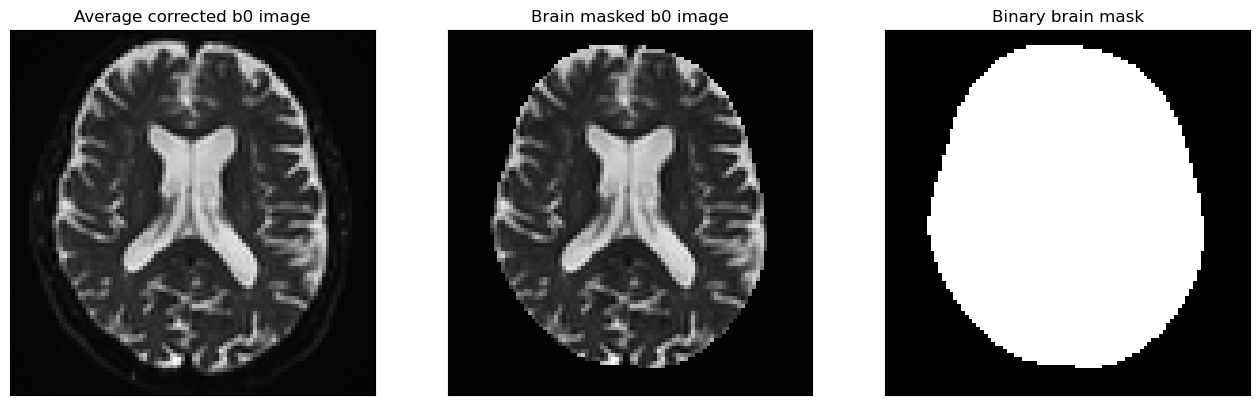

In [21]:
from dipy.segment.mask import median_otsu

#create a binary brain mask
hifi_nodif_brain, hifi_nodif_brain_mask = median_otsu(hifi_nodif, median_radius=4, numpass=4)

#save the brain mask
save_nifti(f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain.nii.gz", hifi_nodif_brain.astype(np.float32), topup_affine)
save_nifti(f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz", hifi_nodif_brain_mask.astype(np.float32), topup_affine)


#plot the mid slice for the original and brain masked data
fig, ax = plt.subplots(1, 3, figsize=(16, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

ax.flat[0].imshow(hifi_nodif[:, :, mid_slice].T, cmap='gray',  interpolation='none' , origin='lower')
ax.flat[0].set_title('Average corrected b0 image')
ax.flat[1].imshow(hifi_nodif_brain[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[1].set_title('Brain masked b0 image')
ax.flat[2].imshow(hifi_nodif_brain_mask[:, :, mid_slice].T, cmap='gray', interpolation='none', origin='lower')
ax.flat[2].set_title('Binary brain mask')

The next step is to create the index.txt file which contains a column of ones, one for each volume in the dwi data, specifying that all volume were acquired with the parameters described by the first row in acqparams.txt.

In [23]:
#check whether the aindex.txt file exists and create it if it doesn't
index_file_path = f"{out_dir}/preprocessing/sub-{sub}/index.txt"

if not os.path.exists(index_file_path):

    # Initialize an empty string
    indx = ""

    # Loop from 1 to the number of volumes in nogibbs_ap with step 1
    for i in range(1, dwi_ap_data.shape[3]+1):
        indx += " 1"  # Append " 1" to the string indx

    # Write indx to a file named index.txt
    with open(index_file_path, "w") as f:
        f.write(indx.strip())  # Strip leading/trailing whitespace and write to file

Now we are ready to run eddy, using the subprocesses module again. As EDDY performs a simultaneous registration of all volumes in the dataset, it is quite memory and CPU hungry. Therefore this step will take a very long time. 

In [32]:
#check whether the eddy unwarped file exists and if not run eddy
eddy_file_path = f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images.nii.gz"

if not os.path.exists(eddy_file_path):

    #create an acqparams file for the eddy command including only the first line, given that only AP data will be passed to eddy
    acq_eddy_file_path = f"{out_dir}/preprocessing/sub-{sub}/acqparams_eddy.txt"

    #create the acqparams_eddy.txt file
    line = [
        "0 -1 0 0.0266003\n"
    ]

    # Open the file in write mode and write the lines
    with open(acq_eddy_file_path, 'w') as file:
        file.writelines(line)

    # Define the command to load the FSL module and then execute eddy
    def run_eddy(input_file, mask_file, acq_params_file, index_file, bvecs_file, bvals_file, output_base_topup, output_base_eddy):

        #command to run eddy 
        command = (
            f'module load fsl/6.0.5; '
            f'eddy --imain={input_file} '
            f'--mask={mask_file} ' 
            f'--index={index_file} '
            f'--acqp={acq_params_file} '
            f'--bvecs={bvecs_file} '
            f'--bvals={bvals_file} '
            f'--fwhm=0 '
            f'--topup={output_base_topup} '
            f'--flm=quadratic '
            f'--out={output_base_eddy}'
        )

        # Execute the command
        try:
            result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print("EDDY completed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"An error occurred: {e}")
            print("Output:\n", e.stdout)
            print("Errors:\n", e.stderr)


    # Define paths to the relevant files
    input_file_eddy =  f"{out_dir}/preprocessing/sub-{sub}/nogibbs_ap_mppca.nii.gz"
    acq_params_file = f"{out_dir}/preprocessing/sub-{sub}/acqparams.txt"
    mask_file = f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz"
    index_file = f"{out_dir}/preprocessing/sub-{sub}/index.txt"
    bvecs_file = f"{dwi_path}/{dwi_ap_bvec}"
    bvals_file = f"{dwi_path}/{dwi_ap_bval}"
    output_base_topup = f"{out_dir}/preprocessing/sub-{sub}/topup_ap_pa_b0"
    output_base_eddy = f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images"


    # Run EDDY
    run_eddy(input_file_eddy, mask_file, acq_params_file, index_file, bvecs_file, bvals_file, output_base_topup, output_base_eddy)


EDDY completed successfully.


You will find that eddy has produced three output files: eddy_unwarped_images.nii.gz, eddy_unwarped_images.rotated_bvecs and eddy_unwarped_images.eddy_parameters. The former of those is the "main result" and contains the data corrected for susceptibility, eddy currents and subject movements. 

This concludes the pre-processing steps and we are now ready for model fitting, which we will cover in Tutorial 3. 

# Quality Control

## EDDY QC

As we have seen, dMRI data can be affected by many hardware or subject-specific artefacts. If undetected, these artefacts can bias downstream analysis. Quality control is therefore very important - always look at your data! In large population studies, manual quality control may not be practical. 

An FSL tool called eddy_quad provides automatic quality control at both the single subject and group level. For more info see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/eddyqc.

For each subject, eddy_quad will generate a pdf file with a data quality report, including information about subject movement, outliers, signal-to-noise ratio, amongst other metrics.

![Example of eddy_quad output](eddy_quad_pdf.png)




In [33]:
#check whether the eddy qc folder exists and if not run eddy qc
qc_file_path = f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images.qc"

if not os.path.exists(qc_file_path):
   
    # Define the command to load the FSL module and then execute eddy qc
    def run_eddy_quad(input_file, mask_file, acq_params_file, index_file, bvals_file):

        #command to run eddy 
        command = (
            f'module load fsl/6.0.5; '
            f'eddy_quad {input_file} '
            f'-m {mask_file} ' 
            f'-idx {index_file} '
            f'-par {acq_params_file} '
            f'-b {bvals_file}'
        )

        # Execute the command
        try:
            result = subprocess.run(command, shell=True, check=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print("EDDY QUAD completed successfully.")
        except subprocess.CalledProcessError as e:
            print(f"An error occurred: {e}")
            print("Output:\n", e.stdout)
            print("Errors:\n", e.stderr)


    # Define paths to the relevant files
    input_file_eddy_qc = f"{out_dir}/preprocessing/sub-{sub}/eddy_unwarped_images"
    acq_params_file = f"{out_dir}/preprocessing/sub-{sub}/acqparams_eddy.txt"
    mask_file = f"{out_dir}/preprocessing/sub-{sub}/hifi_nodif_brain_mask.nii.gz"
    index_file = f"{out_dir}/preprocessing/sub-{sub}/index.txt"
    bvals_file = f"{dwi_path}/{dwi_ap_bval}"
    
    # Run EDDY
    run_eddy_quad(input_file_eddy_qc, mask_file, acq_params_file, index_file, bvals_file)


EDDY QUAD completed successfully.


Quality control can also be performed at the group level, using the eddy_squad command. This command reads all the single subject outputs from eddy_quad, generates study-wise reports and can optionally update single subject reports, indicating how the subject’s dataset compares to other data, using a ‘traffic light’ system (see below and example of an updated QC report). Lastly, eddy_squad also allows to report QC indices based on user-provided variables.

![Example of eddy_squad output with 'traffic light' system](eddy_squad_pdf.png)